# News Headlines Sentiment Analysis to Evaluate Tweets

Note: Real News = 0, Fake News = 1, based on coding convention that True = 0, False = 1

In [1]:
import nltk
import string

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from matplotlib import cm
from wordcloud  import WordCloud

from nltk.probability import FreqDist
from nltk.corpus      import stopwords
from nltk.tokenize    import sent_tokenize, word_tokenize
from nltk.stem        import PorterStemmer, WordNetLemmatizer

from imblearn.combine        import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn          import metrics
from sklearn.metrics  import confusion_matrix, plot_confusion_matrix, classification_report, make_scorer, accuracy_score
from sklearn.datasets import make_classification

from sklearn.preprocessing           import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection         import train_test_split, GridSearchCV
from sklearn.model_selection         import cross_validate, RepeatedStratifiedKFold

from sklearn.naive_bayes   import MultinomialNB, GaussianNB
from sklearn.ensemble      import RandomForestClassifier, BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.svm           import SVC

np.random.seed(0)

## Combining All Datasets

In [120]:
esocinfo = pd.read_csv('Data/Headlines/ESOCheadlines_eng.csv')
zenodoinfo = pd.read_csv('Data/Headlines/Zenodoheadlines.csv')
fakeinfo = pd.read_csv('Data/Headlines/fakeheadlines.csv')
trueinfo = pd.read_csv('Data/Headlines/trueheadlines.csv')
sarcasminfo = pd.read_csv('Data/Headlines/sarc_headlines.csv')

In [121]:
df = pd.concat([esocinfo, zenodoinfo, fakeinfo, trueinfo, sarcasminfo], ignore_index=True)
#shape: (111928, 2)

### Frequency of Target Variable
RECALL: True = 0, Fake/Misinformation = 1 <br>
The headlines dataset contains 55% True Headlines and 45% Fake/Misinformation Headlines

In [4]:
df.real_or_fake.value_counts()

0    61114
1    50814
Name: real_or_fake, dtype: int64

## Data Instantiation and Lemmatization

In [125]:
data = df['headline']
target = df['real_or_fake']

processed_data = [d.split() for d in data.to_list()]

lemmatizer = WordNetLemmatizer()
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

### Lemmatized Data

In [126]:
X_lem = lemmatized_output
y_lem = target

## Stop Words List

In [127]:
sw_list  = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '27', '1', "'ve",
            '-', '–', '—', "n't", 'https', '2', "'re", "'m'", '3', '..', 'ca', "'s", 'amp']

## TFIDF Vectorization
#### Keeping all rows but Maximum Features after vectorization: 5000

In [128]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)

tfidf = TfidfVectorizer(stop_words=sw_list, max_features=5000)
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem  = tfidf.transform(X_test_lem)
#shape train: (89542, 5000)
#shape test: (22386, 5000)

#### Average Number Of Elements And Matrix Sparsity

In [9]:
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Text: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Text: 6.913180406959863
Percentage of columns containing ZERO: 0.998617363918608


### Dense Data

In [8]:
train = tfidf_data_train_lem.toarray()
test  = tfidf_data_test_lem.toarray()

### Data Seperability
#### PCA Transformation

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train)
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca['Target'] = y_lem

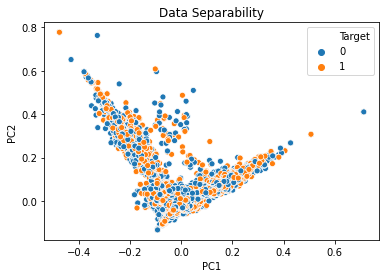

In [14]:
sns.scatterplot(x=X_pca['PC1'], y=X_pca['PC2'],
                hue=X_pca['Target']).set_title('Data Separability');

## SMOTETomek Data
SMOTETomek data created from 89542 rows (scaled down from full headlines dataset via tfidf vectorization with maximum features set to 5000) OR about 80% of the total dataset

In [129]:
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_res, y_res = resample.fit_resample(tfidf_data_train_lem, y_train_lem)

In [9]:
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res, test_size=0.20, random_state=1)
#shape X_res_train: (78076, 5000)
#shape X_res_test: (19520, 5000)

Resulting SMOTETomek dataset has shape (97596, 5000) OR about 87% of the size of the total dataset 

### SMOTETomek Dense Data

In [11]:
train_res = X_res_train.toarray()
test_res = X_res_test.toarray()

#### All SMOTETomek Data for DataFrame
Will use for subsets of SMOTETomek Data for use in GridSearch

In [130]:
X_resamp_dense = X_res.toarray()

In [131]:
resample_df = pd.DataFrame(data=X_resamp_dense)
resample_df['y_res'] = y_res

#### DataFrames of Subsets of SMOTETomek Data

HALF SAMPLE of SMOTETomek data - about 44% of the total dataset

In [132]:
df_resample_half = resample_df.sample(frac=0.5, random_state=1)
df_resample_half.reset_index(inplace=True, drop=True)

In [133]:
X_res_half_df = df_resample_half.drop(['y_res'], axis=1)
y_res_half_df = df_resample_half['y_res']
#shape: (48798, 5000)

In [134]:
X_res_half_train, X_res_half_test, y_res_half_train, y_res_half_test = train_test_split(X_res_half_df, y_res_half_df, test_size=0.20, random_state=1)

15% SAMPLE of SMOTETomek data - about 13% of the total datset

In [12]:
df_resample_15 = resample_df.sample(frac=0.15, random_state=1)
df_resample_15.reset_index(inplace=True, drop=True)

In [13]:
X_res_15_df = df_resample_15.drop(['y_res'], axis=1)
y_res_15_df = df_resample_15['y_res']
#shape: (14639, 5000)

In [14]:
X_res_15_train, X_res_15_test, y_res_15_train, y_res_15_test = train_test_split(X_res_15_df, y_res_15_df, test_size=0.20, random_state=1)

# Base Models

## Gausian Naive Bayes - all data

In [9]:
gnb = GaussianNB()

gnb.fit(train, y_train_lem)

gnb_train_preds_lem = gnb.predict(train)
gnb_test_preds_lem  = gnb.predict(test)

print(classification_report(y_train_lem, gnb_train_preds_lem))
print(classification_report(y_test_lem, gnb_test_preds_lem))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     48932
           1       0.80      0.72      0.76     40610

    accuracy                           0.79     89542
   macro avg       0.79      0.79      0.79     89542
weighted avg       0.79      0.79      0.79     89542

              precision    recall  f1-score   support

           0       0.77      0.84      0.80     12182
           1       0.78      0.70      0.74     10204

    accuracy                           0.77     22386
   macro avg       0.78      0.77      0.77     22386
weighted avg       0.77      0.77      0.77     22386



## Gausian Naive Bayes - SMOTETomek data
SMOTETomek data created from 89542 rows OR about 80% of the total dataset

In [47]:
gnb_smote = GaussianNB()

gnb_smote.fit(train, y_train_lem)

gnb_smote_train_preds = gnb.predict(train_res)
gnb_smote_test_preds  = gnb.predict(test_res)

print(classification_report(y_res_train, gnb_smote_train_preds))
print(classification_report(y_res_test, gnb_smote_test_preds))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79     38865
           1       0.82      0.68      0.75     39211

    accuracy                           0.77     78076
   macro avg       0.78      0.77      0.77     78076
weighted avg       0.78      0.77      0.77     78076

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      9799
           1       0.83      0.69      0.75      9721

    accuracy                           0.77     19520
   macro avg       0.78      0.77      0.77     19520
weighted avg       0.78      0.77      0.77     19520



## Random Forest Classifier - all data

In [13]:
rf = RandomForestClassifier(random_state=123)

rf.fit(train, y_train_lem)

rf_train_preds_lem = rf.predict(train)
rf_test_preds_lem = rf.predict(test)

print(classification_report(y_train_lem, rf_train_preds_lem))
print(classification_report(y_test_lem, rf_test_preds_lem))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48932
           1       1.00      1.00      1.00     40610

    accuracy                           1.00     89542
   macro avg       1.00      1.00      1.00     89542
weighted avg       1.00      1.00      1.00     89542

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     12182
           1       0.93      0.88      0.91     10204

    accuracy                           0.92     22386
   macro avg       0.92      0.92      0.92     22386
weighted avg       0.92      0.92      0.92     22386



In [23]:
#For use in visualizations
base_rf_feat_imp = rf.feature_importances_

## Random Forest Classifier - SMOTETomek data 
SMOTETomek data created from 89542 rows OR about 80% of the total dataset

In [29]:
rf_smote = RandomForestClassifier(random_state=123)

rf_smote.fit(train_res, y_res_train)

rf_smote_train_preds = rf.predict(train_res)
rf_smote_test_preds = rf.predict(test_res)

print(classification_report(y_res_train, rf_smote_train_preds))
print(classification_report(y_res_test, rf_smote_test_preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     38865
           1       1.00      0.95      0.97     39211

    accuracy                           0.97     78076
   macro avg       0.97      0.97      0.97     78076
weighted avg       0.97      0.97      0.97     78076

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      9799
           1       1.00      0.95      0.97      9721

    accuracy                           0.97     19520
   macro avg       0.97      0.97      0.97     19520
weighted avg       0.97      0.97      0.97     19520



In [31]:
#For use in visualizations
base_rfsmote_feat_imp = rf_smote.feature_importances_

## Support Vector Machine - all data
This model was originally run in another notebook, entitled models_all_data.ipynb. An image of the code and resulting classification report is seen below as this model has a very high computational cost, taking two days to run. Upon examination of the classification report, I chose to forgo another SVC model on the SMOTETomek data as this base model performed more poorly than the other base models.

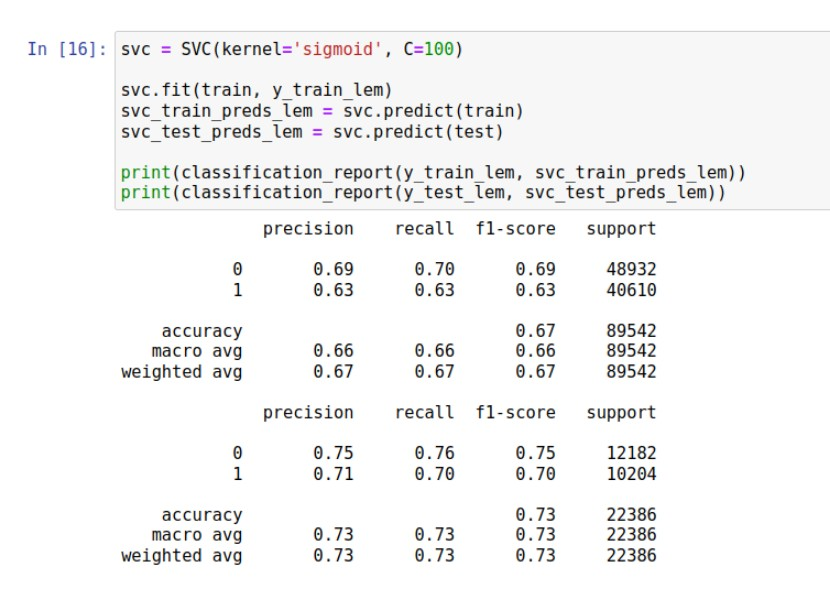

# GridSearch 
Due to the size of the dataset, in order to run an exhaustive GridSearch for Gaussian Naive Bayes and Random Forest Classifier models, subsets of the SMOTETomek data were used.

## Gaussian Naive Bayes GridSearch - SMOTETomek data 
NOTE: SMOTETomek data useed 89542 rows OR about 80% the size of the total dataset. The GaussianNB GridSearch used half of the SMOTETomek data meaning 48798 rows were utilized i.e. about 44% of the size of total dataset.

In [135]:
gnb_params = {'var_smoothing': np.logspace(0,-9,num=100)}

gnb_smote_grid = GridSearchCV(estimator=GaussianNB(), param_grid=gnb_params, verbose=1, cv=5, n_jobs=1)

gnb_smote_grid.fit(X_res_half_train, y_res_half_train)

gnb_smote_grid_train_preds = gnb_smote_grid.predict(X_res_half_train)
gnb_smote_grid_test_preds = gnb_smote_grid.predict(X_res_half_test)

print('\033[1m' + 'Gaussian Naive Bayes Train Report:\n' + '\033[0m')
print(classification_report(y_res_half_train, gnb_smote_grid_train_preds))
print('\033[1m' + 'Gaussian Naive Bayes Test Report:\n' + '\033[0m')
print(classification_report(y_res_half_test, gnb_smote_grid_test_preds))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Gaussian Naive Bayes Train Report:

              precision    recall  f1-score   support

           0       0.86      0.79      0.82     19579
           1       0.81      0.87      0.83     19461

    accuracy                           0.83     39040
   macro avg       0.83      0.83      0.83     39040
weighted avg       0.83      0.83      0.83     39040

Gaussian Naive Bayes Test Report:

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      4814
           1       0.78      0.85      0.82      4946

    accuracy                           0.80      9760
   macro avg       0.81      0.80      0.80      9760
weighted avg       0.81      0.80      0.80      9760



In [137]:
best_gnb_smote_grid = gnb_smote_grid.best_estimator_
best_gnb_smote_grid

GaussianNB(var_smoothing=0.0533669923120631)

In [140]:
gnb_score = gnb_smote_grid.best_score_
gnb_score

0.7918545081967213

In [143]:
print('Train Accuracy : %.3f'%gnb_smote_grid.best_estimator_.score(X_res_half_train, y_res_half_train))
print('Test Accuracy : %.3f'%gnb_smote_grid.best_estimator_.score(X_res_half_test, y_res_half_test))
print('Best Accuracy Through Grid Search : %.3f'%gnb_smote_grid.best_score_)

Train Accuracy : 0.829
Test Accuracy : 0.805
Best Accuracy Through Grid Search : 0.792


Gaussian Naive Bayes Train Data Confusion Matrix:



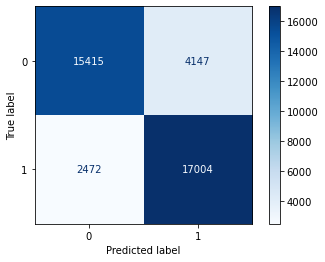

Gaussian Naive Bayes Test Data Confusion Matrix:



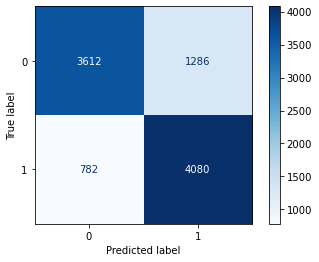

In [20]:
print('\033[1m' + 'Gaussian Naive Bayes Train Data Confusion Matrix:\n')
plot_confusion_matrix(gnb_smote_grid, X_res_half_train, y_res_half_train, cmap=plt.cm.Blues)
plt.show()
print('\033[1m' + 'Gaussian Naive Bayes Test Data Confusion Matrix:\n')
plot_confusion_matrix(gnb_smote_grid, X_res_half_test, y_res_half_test, cmap=plt.cm.Blues)
plt.show()

## Random Forest GridSearch - SMOTETomek data 
NOTE: SMOTETomek data created 89542 rows OR about 80% the size of the total dataset. Random Forest GridSearch used 15% of SMOTETomek data meaning 14639 rows were utilized i.e. about 13% of the size of total dataset.

In [15]:
rf_params = {'n_estimators': [10,20], 'criterion':['gini', 'entropy'],
            'max_depth':[10,15,20]}

rf_smote_grid = GridSearchCV(RandomForestClassifier(), rf_params, scoring='f1_weighted',
                      return_train_score=True, verbose=1, n_jobs=-1)

rf_smote_grid.fit(X_res_15_train, y_res_15_train)

rf_smote_grid_train_preds = rf_smote_grid.predict(X_res_15_train)
rf_smote_grid_test_preds = rf_smote_grid.predict(X_res_15_test)

print('\033[1m' + 'Random Forest Classifier Train Report:\n' + '\033[0m')
print(classification_report(y_res_15_train, rf_smote_grid_train_preds))
print('\033[1m' + 'Random Forest Classifier Test Report:\n' + '\033[0m')
print(classification_report(y_res_15_test, rf_smote_grid_test_preds))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest Classifier Train Report:

              precision    recall  f1-score   support

           0       0.87      0.60      0.71      5874
           1       0.69      0.91      0.79      5837

    accuracy                           0.76     11711
   macro avg       0.78      0.76      0.75     11711
weighted avg       0.78      0.76      0.75     11711

Random Forest Classifier Test Report:

              precision    recall  f1-score   support

           0       0.80      0.54      0.65      1421
           1       0.67      0.88      0.76      1507

    accuracy                           0.71      2928
   macro avg       0.74      0.71      0.70      2928
weighted avg       0.73      0.71      0.70      2928



Random Forest Classifier Train Data Confusion Matrix:



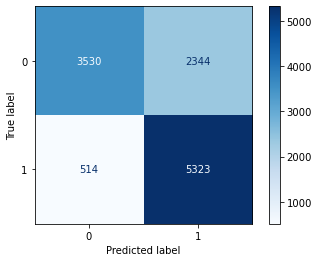

Random Forest Classifier Test Data Confusion Matrix:



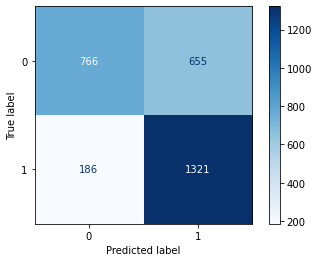

In [16]:
print('\033[1m' + 'Random Forest Classifier Train Data Confusion Matrix:\n')
plot_confusion_matrix(rf_smote_grid, X_res_15_train, y_res_15_train, cmap=plt.cm.Blues)
plt.show()
print('\033[1m' + 'Random Forest Classifier Test Data Confusion Matrix:\n')
plot_confusion_matrix(rf_smote_grid, X_res_15_test, y_res_15_test, cmap=plt.cm.Blues)
plt.show()

## Post-GridSearch Random Forest Classifier - all SMOTETomek data
### Using best parameter citerion='gini' found from first GridSearch
The GridSearch best parameters n_estimators=20 and max_depth=20 did not hold for the full SMOTETomek data.

In [17]:
rf_smote_best = RandomForestClassifier(n_estimators=50, max_depth=60, criterion='gini', 
                                       verbose=1, random_state=123, n_jobs=-1)

rf_smote_best.fit(train_res, y_res_train)

rf_smote_best_train_preds = rf_smote_best.predict(train_res)
rf_smote_best_test_preds = rf_smote_best.predict(test_res)

print(classification_report(y_res_train, rf_smote_best_train_preds))
print(classification_report(y_res_test, rf_smote_best_test_preds))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.78      0.93      0.85     38865
           1       0.92      0.75      0.82     39211

    accuracy                           0.84     78076
   macro avg       0.85      0.84      0.84     78076
weighted avg       0.85      0.84      0.84     78076

              precision    recall  f1-score   support

           0       0.75      0.89      0.81      9799
           1       0.87      0.70      0.77      9721

    accuracy                           0.79     19520
   macro avg       0.81      0.79      0.79     19520
weighted avg       0.81      0.79      0.79     19520



Random Forest Classifier Train Data Confusion Matrix:



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.4s finished


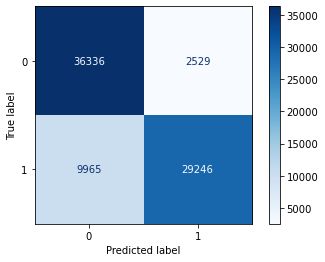

Random Forest Classifier Test Data Confusion Matrix:



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.1s finished


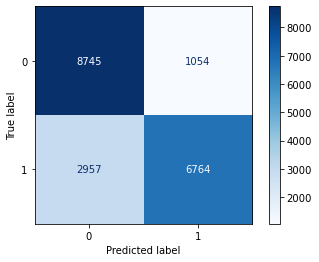

In [18]:
print('\033[1m' + 'Random Forest Classifier Train Data Confusion Matrix:\n')
plot_confusion_matrix(rf_smote_best, train_res, y_res_train, cmap=plt.cm.Blues)
plt.show()
print('\033[1m' + 'Random Forest Classifier Test Data Confusion Matrix:\n')
plot_confusion_matrix(rf_smote_best, test_res, y_res_test, cmap=plt.cm.Blues)
plt.show()

# Tweets
The following variable, tweets, is a pandas Series containing tweets that are tokenized and in lower-case as well as run through a stop words list.

In [114]:
tweets = pd.read_csv('Data/CleanedTweets/token_tweets.csv')
#shape (7638, 1)

## Prepare Unseen Tweets Data for Gaussian Naive Bayes Model

### Lemmatization

In [21]:
tweet_data = tweets['clean_tweets']

tweet_processed_data = [d.split() for d in tweet_data.to_list()]

tweet_lemmatizer = WordNetLemmatizer()
tweet_lemmatized_output = []

for listy in tweet_processed_data:
    tweet_lemmed = ' '.join([tweet_lemmatizer.lemmatize(w) for w in listy])
    tweet_lemmatized_output.append(tweet_lemmed)

In [22]:
tweet_unseen_data = tweet_lemmatized_output

### TFIDF Vectorization

In [23]:
unseen_vectorized = tfidf.transform(tweet_unseen_data)

In [25]:
dense_unseen = unseen_vectorized.toarray()

### Classification Predictions of Unseen Tweets from Gaussian Naive Bayes Model

#### Predictions

In [26]:
tweet_preds = gnb_smote_grid.predict(dense_unseen)

#### Combine Original, Unaltered Tweets with Cleaned Tweets and Predictions for Dataframe and .csv File

In [40]:
preds_df = pd.Series(tweet_preds)
twts_preds_df = pd.concat([engtweets['tweet'], tweets, preds_df], axis=1)

twts_preds_df.rename(columns={0: 'prediction'}, inplace=True)

twts_preds_df.to_csv('Data/twts_preds', index=False)

In [16]:
#Read Dataframe with Predictions back into notebook
predictions = pd.read_csv('Data/twts_preds')

#### Frequencies of Unseen Data Target Variable
RECALL: True = 0, Fake/Misinformation = 1 <br>
Unseen data predictions contain 41% Factual Tweets and 59% Fake/Misinformation Tweets

In [59]:
twts_preds_df['prediction'].value_counts()

1    4489
0    3149
Name: prediction, dtype: int64

### Individual Tweets Predicted as Misinformation

#### Correctly Flagged

In [144]:
predictions['tweet'][48]

'Covid is communism'

In [145]:
predictions['tweet'][40]

"@EricMMatheny @LateNightBobbyD WHY would ANYONE STOP FREE CHOICE?! ESP WHEN IT COMES TO A VACCINE THAT DOESN'T STOP YOU FROM GETTING OR GIVING COVID19 TO OTHERS, supposedly only LESSONS the symptoms! Well HELL, so does Tylenol!! WAKE UP! This IS Socialist Government control! That IS the Demoncratic party!"

In [146]:
predictions['tweet'][7599]

'@david_shane One of the largest payoff schemes the world has ever seen. Why would testing companies ever want covid to end.'

In [147]:
predictions['tweet'][7611]

'Communism has killed more people then the Holocaust and COVID-19 COMBINED.'

In [148]:
predictions['tweet'][22]

'Anti-Vaxxer MAGA Cartoonist Has COVID, Will Self-treat With Ivermectin, Beet Juice   https://t.co/o9p1xFY0Rc'

In [150]:
predictions['tweet'][2]

'@Iroserebel @ILYM333 Sounds like that are suing the CDC for fraud - passing off influenza as covid! Thanks for sharing.... This could be huge! ♥️'

#### Incorrectly Flagged
While technically not misinformation, these tweets are still misleading

In [151]:
predictions['tweet'][7595]

'Excited to start my new ivermectin routine to prevent COVID. What do you mean this is dog medicine?! (This tweet is satire, please spare me)  https://t.co/FxlYtmRYQL'

In [109]:
predictions['tweet'][7579]

'Rock boasted about the size of the crowd and claimed that "there is nothing the mainstream media, internet or social media trolls can do but look at this pic and weep, knowing they will never beat us."Kid Rock Cancels  Shows Due To COVID-19 Illness #Covid  https://t.co/vb97e3G5mk'

In [57]:
predictions['tweet'][7609]

'@briantylercohen Literally such a minority. I don’t even know why it makes news. While most of us our continuing to live our lives, these people are OBSESSED with COVID and mandates. It’s taken over who they are. It’s sad really.'

In [152]:
predictions['tweet'][7596]

'ICYMI: #FoxNews Employees must carry a version of a #vaccinepassport.  Seth Meyers Slams Fox News for Saying Horse Dewormer Ivermectin Cures COVID | Vanity Fair  https://t.co/ChXr2rJMk9'

In [153]:
predictions['tweet'][7618]

'Some B.C. residents are seeking out horse dewormer to treat COVID-19 – Victoria\xa0News  https://t.co/sFFXAntG45'

In [154]:
predictions['tweet'][7616]

'@RepRonnyJackson @GOPLeader @RepChrisStewart I love republicans who put out misinformation on covid -19 then push animal dewarmer for there constituents to take, try anything they say.other than the vaccine😁'

#### Examples in Conclusion

In [56]:
predictions['tweet'][7610]

'COVID Vaccine Injury Reports Jump by 27,000 in One Week, FDA Pulls ‘Bait and Switch’ With Pfizer Vaccine Approval  https://t.co/ByEetLFOIp'

In [38]:
predictions['tweet'][7605]

'@FlatEarthGang All the current covid related deaths in NSW are on Berijiklian and Hazzard.'

In [44]:
predictions['tweet'][7589]

'@civilizedrights @Lexham_1 There is a reason why reasonable people don\'t readily or easily trust BIG PHARMA &amp; their bought &amp; paid government lackeys.  Nothing said thus far about COVID has been reasonable from its "origin" to its emergency use status &amp; not to mention its subject to quickly change efficacy.  https://t.co/gWstNlkIcl'

In [19]:
predictions['tweet'][7616]

'@RepRonnyJackson @GOPLeader @RepChrisStewart I love republicans who put out misinformation on covid -19 then push animal dewarmer for there constituents to take, try anything they say.other than the vaccine😁'

# Visualizations
I combined the two COVID misinformation datasets from Zenodo and ESOC in order to get an overall picture of the data as it directly pertains to COVID. Additionally, I used the information gleaned in post modeleing analysis to compare and contrast.

#### A second stop words list was created that included variations of COVID for elimination so as to ascertain non-COVID prominent words in the COVID misinformation headlines. 

In [123]:
sw_list2  = stopwords.words('english')
sw_list2 += list(string.punctuation)
sw_list2 += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '27', '1', "'ve",
            '-', '–', '—', "n't", 'https', '2', "'re", "'m'", '3', '..', 'ca', "'s", 'amp', 
            'coronavirus', 'covid', 'covid-19', 'coronavirus.', 'covid-19.']

### Bar Graphs
#### Word Frequencies Raw Data from COVID Misinformation Headlines

181581


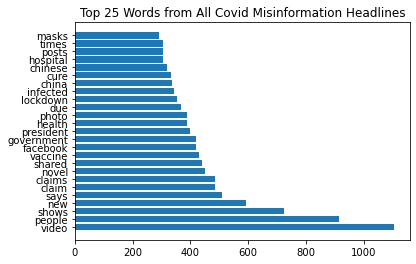

In [21]:
all_covid_misinfo = pd.concat([esocinfo, zenodoinfo], ignore_index=True)
data_all_covid_misinfo = all_covid_misinfo['headline']
all_covid_misinfo_words = [d.split() for d in data_all_covid_misinfo.tolist()]

total_all_covid_misinfo = set()
for words in all_covid_misinfo_words:
    total_all_covid_misinfo.update([w.lower for w in words])
print(len(total_all_covid_misinfo))

clean_all_covid_misinfo_words = [item.lower() for sublist in all_covid_misinfo_words for item in sublist if item.lower() not in sw_list2]
all_covid_misinfo_freq = FreqDist(clean_all_covid_misinfo_words)
top25_all_covid_misinfo = all_covid_misinfo_freq.most_common(25)

top25_all_covid_misinfodf = pd.DataFrame(top25_all_covid_misinfo)
plt.barh(top25_all_covid_misinfodf[0], top25_all_covid_misinfodf[1])
plt.title('Top 25 Words from All Covid Misinformation Headlines')
plt.savefig('final_top25_mis_covid_head.png')
plt.show()

#### Word Frequencies Raw Data from All Headlines

1276621


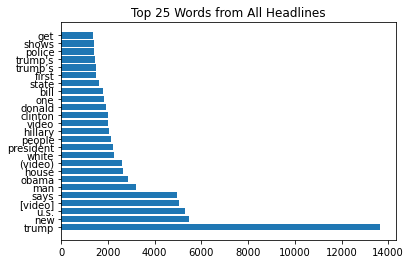

In [124]:
all_covid_misinfo = pd.concat([esocinfo, zenodoinfo], ignore_index=True)
data_all_headlines = df['headline']
all_headlines_words = [d.split() for d in data_all_headlines.tolist()]

total_all_headlines = set()
for words in all_headlines_words:
    total_all_headlines.update([w.lower for w in words])
print(len(total_all_headlines))

clean_all_headlines_words = [item.lower() for sublist in all_headlines_words for item in sublist if item.lower() not in sw_list2]
all_headlines_freq = FreqDist(clean_all_headlines_words)
top25_all_headlines = all_headlines_freq.most_common(25)

top25_all_headlinesdf = pd.DataFrame(top25_all_headlines)
plt.barh(top25_all_headlinesdf[0], top25_all_headlinesdf[1])
plt.title('Top 25 Words from All Headlines')
plt.savefig('final_top25_allhead.png')
plt.show()

#### Feature Importances

Random Forest - All Data 

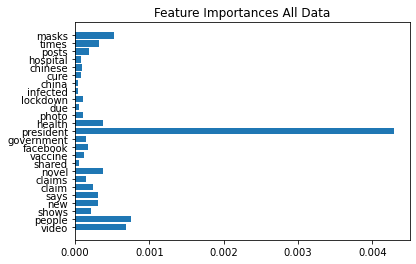

In [42]:
plt.barh(top25_all_covid_misinfodf[0], base_rf_feat_imp[:25])
plt.title('Feature Importances All Data')
plt.savefig('base_rf_FeatImp.png')
plt.show()

Random Forest - SMOTETomek Data

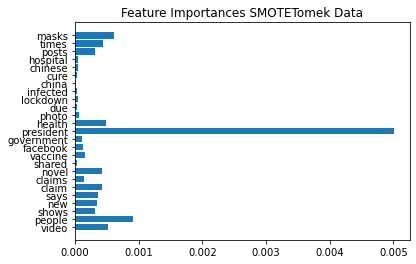

In [41]:
plt.barh(top25_all_covid_misinfodf[0], base_rfsmote_feat_imp[:25])
plt.title('Feature Importances SMOTETomek Data')
plt.savefig('base_rfsmote_FeatImp.png')
plt.show()